# Support Vector Machine (SVM)

A **Support Vector Machine (SVM)** is a supervised machine learning algorithm primarily used for binary classification tasks. In its simplest form, the **hard-margin linear SVM** aims to find a hyperplane that perfectly separates data points of two classes. The algorithm searches for the hyperplane that maximizes the margin, which is the distance between the hyperplane and the closest data points from each class, called **support vectors**.

To handle cases where perfect separation is not possible, the **soft-margin SVM** introduces flexibility by allowing some data points to be misclassified or lie within the margin. This is achieved through the use of **slack variables**, which measure the degree of violation of the margin constraints. SVMs can also use the **kernel trick** to implicitly map data into a higher-dimensional space to allow even for processing non-linearly seprable data.

In SVMs we classify based on the sign of the linear hyperplane. To use SVMs for regression tasks, we simply use the hyperplane as such, and in training instead of penalizing slack variables, we penalize divergence from the real value which is larger then some epsilon. That is called **epsilon-insenstive loss**.

In [ ]:
from generated import preprocessing

In [3]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
X, y = preprocessing.X, preprocessing.y
X_train, X_test, y_train, y_test = preprocessing.X_train, preprocessing.X_test, preprocessing.y_train, preprocessing.y_test

def evaluate_model(y_pred, y_test, model_name):
    print(f"\nEvaluation of {model_name}:")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"R2:   {r2_score(y_test, y_pred):.4f}")


### Baseline models

In [4]:
from sklearn.dummy import DummyRegressor

baseline_mean = DummyRegressor(strategy="mean")
baseline_mean.fit(X_train, y_train)
y_pred = baseline_mean.predict(X_test)
evaluate_model(y_pred, y_test, "baseline mean model")

baseline_median = DummyRegressor(strategy="median")
baseline_median.fit(X_train, y_train)
y_pred = baseline_median.predict(X_test)
evaluate_model(y_pred, y_test, "baseline median model")


Evaluation of baseline mean model:
RMSE: 3.6611
MAE:  2.7043
R2:   -0.0139

Evaluation of baseline median model:
RMSE: 3.6999
MAE:  2.7129
R2:   -0.0354


### Model

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

### Hyperparameters

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'svr__C': [1, 10, 100], # 0.01, 0.1
        'svr__epsilon': [0.0001,0.001, 0.01, 0.1], # 0.2, 0.5, 1
        'svr__kernel': ['linear', 'rbf']
    },
    {
        'svr__C': [1, 10, 100], # 0.01, 0.1
        'svr__epsilon': [0.0001,0.001, 0.01, 0.1], # 0.2, 0.5, 1
        'svr__kernel': ['poly'],
        'svr__degree': [2, 3, 4]
    }
]

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [24]:
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'svr__C': 10, 'svr__epsilon': 0.0001, 'svr__kernel': 'rbf'}
Best cross-validation score: 10.314077137727658


### Fixing model and evaluation

In [25]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(C=10, epsilon=0.0001, kernel='rbf'))
]) 

In [26]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

evaluate_model(y_pred, y_test, "SVR")


Evaluation of SVR:
RMSE: 3.1796
MAE:  2.3542
R2:   0.2353


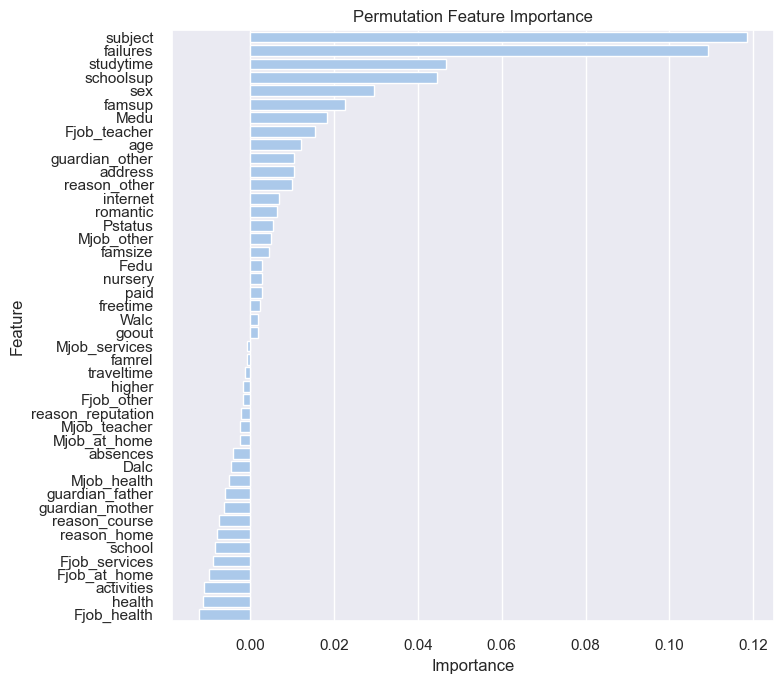

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance


perm_result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)

# Prepare DataFrame for Seaborn
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_result.importances_mean
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 7))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()


In [29]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train.values, 
    feature_names=X.columns.tolist(), 
    mode='regression', 
    verbose=True, 
    random_state=42
)

In [ ]:
for i in range(5):
    exp = explainer.explain_instance(
        X_test.iloc[i].values, 
        pipeline.predict, 
        num_features=5
    )
    exp.save_to_file(f'./explanations/lime_explanation_{i}.html')

In [ ]:
import shap

def pipeline_predict(X):
    if isinstance(X, pd.DataFrame):
        X = X.values
    return pipeline.predict(X)

X_train_sample = shap.sample(X_train, 100, random_state=42).values

explainer = shap.KernelExplainer(pipeline_predict, X_train_sample)

shap_values = explainer.shap_values(X_test.iloc[:100].values)

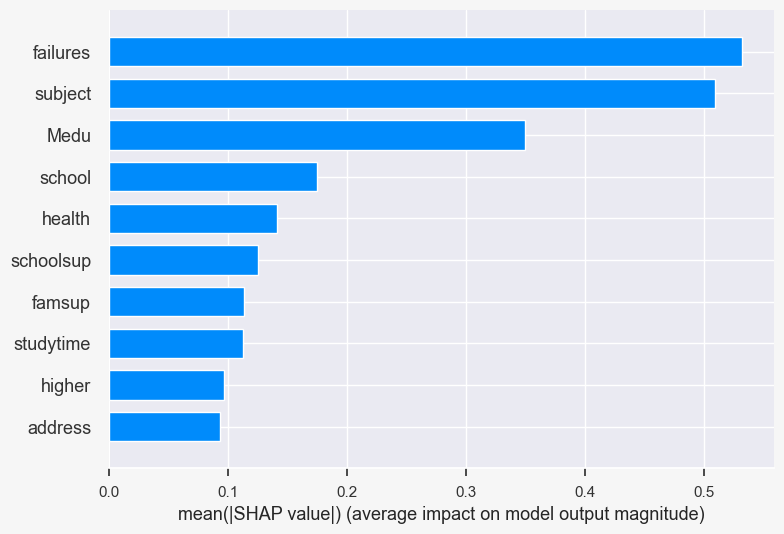

<Figure size 800x550 with 0 Axes>

In [43]:
plt.figure(figsize=(10, 6), facecolor='#f6f6f6')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, rng=42)
plt.tight_layout()

plt.show()

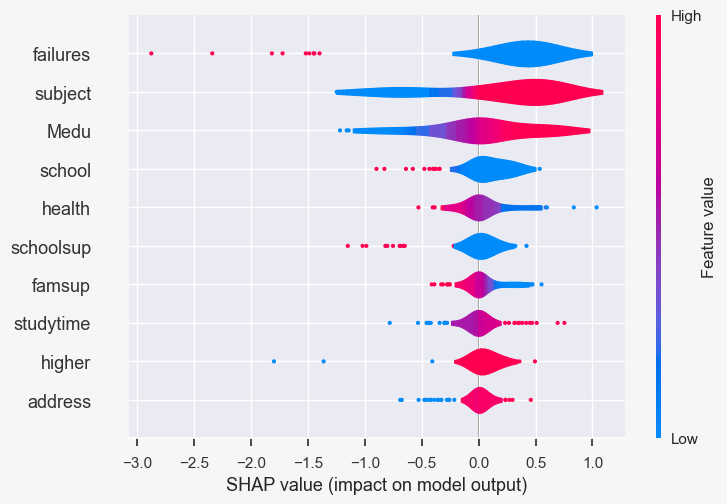

<Figure size 800x550 with 0 Axes>

In [45]:
plt.figure(figsize=(10, 6), facecolor='#f6f6f6')
shap.plots.violin(shap_values, X_test.iloc[:100], max_display=10)
plt.tight_layout()
plt.show()